In [2]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 32.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from IPython.display import display


In [4]:
## For multiple displays per code chunk
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
## Importing data
sale = pd.read_csv("/content/sale_2024_cleaned.csv")
skubal = pd.read_csv("/content/skubal_2024_cleaned.csv")

In [6]:
## Importing Images
sale_photo = mpimg.imread("/content/Sale Photo.png")
skubal_photo = mpimg.imread("/content/Skubal Photo.png")

braves_logo = mpimg.imread("/content/Braves_logo.png")
tigers_logo = mpimg.imread("/content/Tigers_logo.png")

In [7]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2815 entries, 0 to 2814
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pitch_type         2815 non-null   object 
 1   release_speed      2815 non-null   float64
 2   release_pos_x      2815 non-null   float64
 3   release_pos_y      2815 non-null   float64
 4   release_pos_z      2815 non-null   float64
 5   release_spin_rate  2815 non-null   int64  
 6   spin_axis          2815 non-null   int64  
 7   pfx_x              2815 non-null   float64
 8   pfx_z              2815 non-null   float64
 9   plate_x            2815 non-null   float64
 10  plate_z            2815 non-null   float64
 11  sz_top             2815 non-null   float64
 12  sz_bot             2815 non-null   float64
 13  balls              2815 non-null   int64  
 14  strikes            2815 non-null   int64  
 15  outs_when_up       2815 non-null   int64  
 16  inning             2815 

# Exploratory Data Analysis

Before any good modeling project comes an even better exploratory data analysis. There is a lot of cool data that I can learn about through this process. There are a few things I definitely want to highlight:

* Pitch Types by Pitcher
  * Speed
  * H-Break and V-Break
* Most Common Sequences per pitcher
  * What do they start with?
  * What pitch is their strikeout pitch?
* Situational pitching
  * Do they pitch differently with a different number of outs?
  * How do they pitch when they are head in the count versus behind?



# Pitch Types

I first just want to look at the distribution of each pitcher's pitches.

In [8]:
## Aggregating the pitches from the data
sale_pitchtypes = sale['pitch_type'].value_counts().reset_index()
sale_pitchtypes.columns = ['pitch_type', 'count']

skubal_pitchtypes = skubal['pitch_type'].value_counts().reset_index()
skubal_pitchtypes.columns = ['pitch_type', 'count']

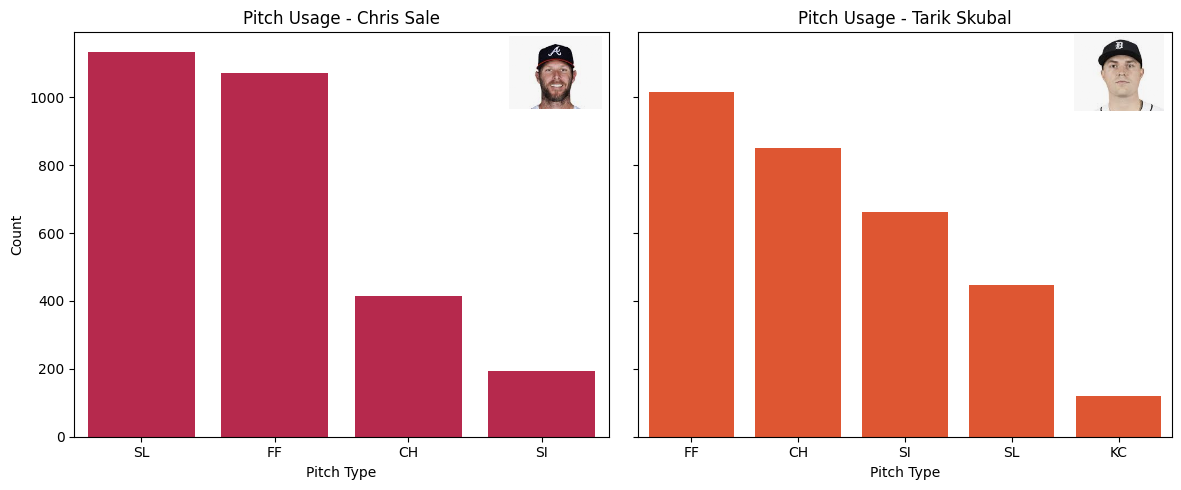

In [9]:
## Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.barplot(x='pitch_type', y='count', data=sale_pitchtypes, ax=axes[0], color="#CE1141")
axes[0].set_title("Pitch Usage - Chris Sale")
axes[0].set_xlabel("Pitch Type")
axes[0].set_ylabel("Count")

sns.barplot(x='pitch_type', y='count', data=skubal_pitchtypes, ax=axes[1], color="#FA4616")
axes[1].set_title("Pitch Usage - Tarik Skubal")
axes[1].set_xlabel("Pitch Type")

## Adding photo
def add_player_photo(ax, image, zoom=0.2):
    imagebox = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(imagebox, (0.9, 0.9), xycoords='axes fraction', frameon=False)
    ax.add_artist(ab)

add_player_photo(axes[0], sale_photo)
add_player_photo(axes[1], skubal_photo)


plt.tight_layout()
plt.show();

The first thing I notice is the similarity in their arsenals. They have all of the same pitches: Four-Seam Fastball, Slider, Changeup, Sinker. Skubal just adds one more pitch to his arsenal, a Knuckle-Curve, but it is rarely used. The cool difference between the two is the different distribution of usage of these pitches. Chris Sale uses his slider more often than his fastball, which I find to be extremely rare. He uses the slider the most, his four seamer the second most, and then we see an extreme drop in his usage in his changeup and his slider. Tarik Skubal's distribution looks to be a bit more linear. He, as expected, uses his four-seam fastball the most. His second most used pitch is a changeup, which sees just a bit less usage than his fastball. The rest of his pitches, in order from most to least used, are sinker, slider, and knuckle-curve. It is cool that these pitchers have such similar arsenals, use them so differently, but were still both the best pitchers in their respective leagues.

Let's dig a little deeper into these pitches. I want to see the speed of them. Are they similar in speed? Super different?

In [10]:
## Pitch speed data
sale_pitchspeed = sale.groupby('pitch_type')['release_speed'].mean().reset_index()
sale_pitchspeed['pitcher'] = 'Chris Sale'

skubal_pitchspeed = skubal.groupby('pitch_type')['release_speed'].mean().reset_index()
skubal_pitchspeed['pitcher'] = 'Tarik Skubal'

pitchspeed_df = pd.concat([sale_pitchspeed, skubal_pitchspeed])

pitchspeed_df['pitch_type'] = pd.Categorical(pitchspeed_df['pitch_type'])

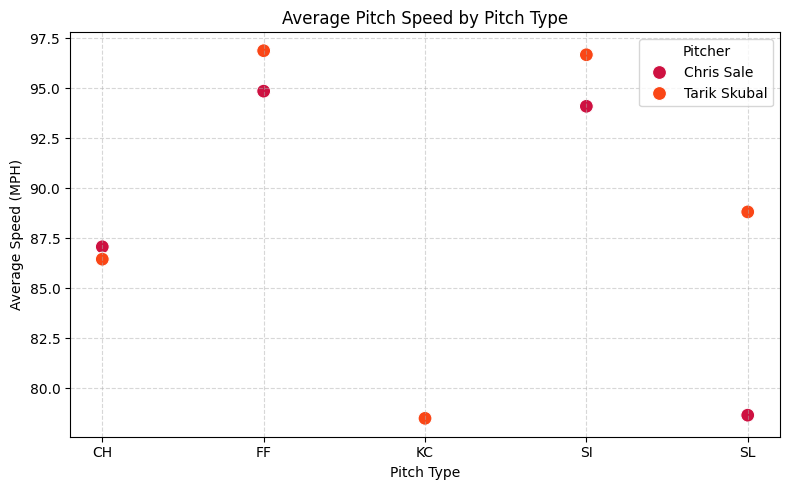

In [11]:
## Plotting
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pitchspeed_df, x='pitch_type', y='release_speed', hue='pitcher', palette=["#CE1141", "#FA4616"], markers=["o", "s"], s=100)

plt.title("Average Pitch Speed by Pitch Type")
plt.xlabel("Pitch Type")
plt.ylabel("Average Speed (MPH)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Pitcher")
plt.tight_layout()
plt.show();


In almost all of his pitches, Skubal is a faster pitcher. His average four seam fastball speed is almost 97.5, while Chris Sale's sits around 95. Skubal's average sinker reaches about 97 mph while Sale's looks to be at about 94 mph. The most eye opening difference on this graph is that Skubal's slider is about 10 mph faster on average than Sale's. Sale's slider averages about 79 mph, which is on the slower end of pitches in Major League Baseball. However, Sale's changeup is just faster on average than Skubal's, but this difference doesn't look to have much meaning. The final pitch, which is Skubal's Knuckle-Curve, averages about 78 mph. This speed is much more similar to Sale's slider than his own slider.

This begs the question: what do their pitches look like in terms of H-break and V-break? It is obvious that speed isn't the reason behind being successful as a major league pitcher, as Sale looks to be on the slower end. So, do they fool batters with the movement on the ball?

In [12]:
## Break data
average_breaks_sale = sale.groupby('pitch_type')[['pfx_x', 'pfx_z']].mean().reset_index()
average_breaks_sale['pitcher'] = 'Chris Sale'

average_breaks_skubal = skubal.groupby('pitch_type')[['pfx_x', 'pfx_z']].mean().reset_index()
average_breaks_skubal['pitcher'] = 'Tarik Skubal'

average_breaks = pd.concat([average_breaks_sale[['pitch_type', 'pfx_x', 'pfx_z', 'pitcher']],
                            average_breaks_skubal[['pitch_type', 'pfx_x', 'pfx_z', 'pitcher']]])
average_breaks.columns = ['pitch_type', 'average_H_break', 'average_V_break', 'pitcher']


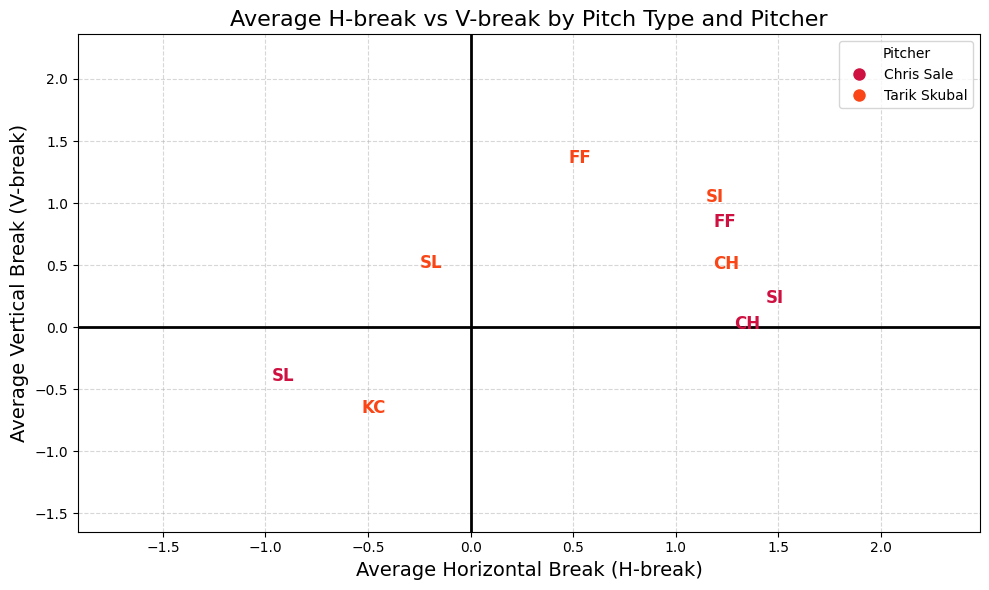

In [13]:
## Plotting
plt.figure(figsize=(10, 6))

## Map of colors for each pitcher
color_map = {'Chris Sale': '#CE1141', 'Tarik Skubal': '#FA4616'}

## Adding text as markers
for i, row in average_breaks.iterrows():
    plt.text(row['average_H_break'], row['average_V_break'], row['pitch_type'],
             fontsize=12, ha='center', va='center',
             color=color_map[row['pitcher']], weight='bold')


plt.title("Average H-break vs V-break by Pitch Type and Pitcher", fontsize=16)
plt.xlabel("Average Horizontal Break (H-break)", fontsize=14)
plt.ylabel("Average Vertical Break (V-break)", fontsize=14)


plt.xlim(average_breaks['average_H_break'].min() - 1, average_breaks['average_H_break'].max() + 1)
plt.ylim(average_breaks['average_V_break'].min() - 1, average_breaks['average_V_break'].max() + 1)

## Create custom legend using invisible points with colors
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Chris Sale',
           markersize=10, markerfacecolor=color_map['Chris Sale']),
    Line2D([0], [0], marker='o', color='w', label='Tarik Skubal',
           markersize=10, markerfacecolor=color_map['Tarik Skubal'])
]

plt.plot([-5, 5], [0, 0], color='black', linestyle='-', linewidth=2)

plt.plot([0, 0], [-5, 5], color='black', linestyle='-', linewidth=2)


# Add the legend to the plot
plt.legend(handles=legend_elements, title="Pitcher")


plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show();


Let's first look at both of their four seam fastballs. Both of their fastballs move upwards and toward the left, as they are both lefty pitchers. However, Skubal's has more V-break, so his moves up more, while Sale's has more H-break, so his moves more left. As for Changeups, their H-breaks and V-breaks are similar as well. They see similar H-break, with Skubal's V-break just being a bit more aggresive. Their sinkers both see positive movement in both directions as well. Skubal's has significantly more V-break, while Sale's has a small bit more H-break. What is most interesting about this is seeing how different their sliders are. Skubal's slider has upward movement, which I feel is somewhat rare. Sale's slider has downward movement. Overall, the H-break on their sliders differs by about an inch, which is quite significant based on the similaries of their other pitches. Skubal's Knuckle Curve moves more similar to Chris Sale's slider than his slider does.

# Pitch Sequencing

What pitches do the pitchers start each at bat with the most? I want to see the differences, as well has how it differs between righty and lefty batters.

In [14]:
def first_pitch_frequency(data, pitcher):
    first_pitch = data[data['pitch_number'] == 1][['stand', 'pitch_type']]
    first_pitch['Pitcher'] = pitcher
    grouped = first_pitch.groupby(['Pitcher', 'stand', 'pitch_type']).size().reset_index(name='Count')
    grouped['Frequency'] = grouped.groupby(['Pitcher', 'stand'])['Count'].transform(lambda x: x / x.sum())

    return grouped.drop(columns=['Count'])

sale_first = first_pitch_frequency(sale, 'Chris Sale')
skubal_first = first_pitch_frequency(skubal, 'Tarik Skubal')

combined_first = pd.concat([sale_first, skubal_first])
combined_first_pivot = combined_first.pivot_table(index=['stand', 'pitch_type'], columns='Pitcher', values='Frequency')
combined_first_pivot.reset_index(inplace=True)
combined_first_pivot


Pitcher,stand,pitch_type,Chris Sale,Tarik Skubal
0,L,CH,0.026786,0.068027
1,L,FF,0.491071,0.040816
2,L,KC,NaN,0.006803
3,L,SI,0.187500,0.727891
4,L,SL,0.294643,0.156463
5,R,CH,0.077966,0.263393
6,R,FF,0.405085,0.401786
7,R,KC,NaN,0.092262
8,R,SI,0.103390,0.061012
9,R,SL,0.413559,0.181548


Let's first look at how Chris Sale and Skubal deal with Left Handed hitters. We see that they approach these hitters very differently. Chris Sale does not have a pitch that he predominantly uses when dealing a lefty the first pitch of the at bat. He uses his fastball 49% of the time, but we still se no majority pitch taking over. Skubal, on the other hand, throws his sinker to lefties about 73% on the first pitch of the bat. Lefty hitters can expect a sinker from Skubal on the first pitch. As for righties, Sale again does not have a pitch that he relies on. He starts with his fastball and slider both 41% of the time. With righties, Skubal approaches at bats similarly to Sale, as there is no pitch he uses more than 50% of the time. He throws his four seam fastball 40% on the first pitch to righties, but that is not frequent enough for righties to assume that this is the first pitch they will see from him.

Let's find out which pitch they strikeout batters most with!


In [15]:
def strikeout_frequency(data, pitcher):
    strikeout = data[data['events'] == 'strikeout'][['stand', 'pitch_type']]
    strikeout['Pitcher'] = pitcher
    grouped_strikeout = strikeout.groupby(['Pitcher', 'stand', 'pitch_type']).size().reset_index(name='Count')
    grouped_strikeout['Frequency'] = grouped_strikeout.groupby(['Pitcher', 'stand'])['Count'].transform(lambda x: x / x.sum())

    return grouped_strikeout.drop(columns=['Count'])

sale_strikeout = strikeout_frequency(sale, 'Chris Sale')
skubal_strikeout = strikeout_frequency(skubal, 'Tarik Skubal')

combined_strikeout = pd.concat([sale_strikeout, skubal_strikeout])
combined_strikeout_pivot = combined_strikeout.pivot_table(index=['stand', 'pitch_type'], columns='Pitcher', values='Frequency')
combined_strikeout_pivot.reset_index(inplace=True)
combined_strikeout_pivot

Pitcher,stand,pitch_type,Chris Sale,Tarik Skubal
0,L,CH,0.025641,0.297297
1,L,FF,0.230769,0.162162
2,L,KC,NaN,0.027027
3,L,SI,0.051282,0.216216
4,L,SL,0.692308,0.297297
5,R,CH,0.102703,0.384615
6,R,FF,0.367568,0.360577
7,R,SI,0.010811,0.173077
8,R,SL,0.518919,0.081731


Before getting into the super nitty-gritty of the cool stuff we learn here, I want to point out my initial observation, which is that there is no row signifying righty Knuckle-Curve combination. I do not think this is a data issue, rather Tarik Skubal did not strikeout any righty hitters using his Knuckle-Curve.

Let's first look at Chris Sale. He used his slider almost 70% of the time to strikeout lefties. In context, this makes sense. A lefty slider to a lefty goes away from a batter, making it harder to hit. Further, if Sale is up in the count, he can throw this out of the zone and maybe get some chase. For righties, its a little less straight forward. He uses his slider about 52% of the time to strikeout righties, which means that can expect a slider more than anything else, but this is nearly 50/50, decreasing its meaning and predictive ability from the batter's end. He uses his fastball about 37% of the time.

Tarik Skubal doesn't seem to have any "strikeout pitch". His pitches are all across the board. With lefties, the most used pitch to strikeout batters is changeup, but that is only 30% of the time. We see a bit more frequency pattern with righties, where changeup and fastball are used about 75% of the time. Technically, batters can expect either of these two pitches when they have two strikes. However, they are very different pitches, which can be seen in both the velocity graphs and movement graphs.

This would make me think that for Chris Sale, at least, we would see sliders more in the end of the at-bat, and other pitches in the beginning. Let's explore usage along at-bats.



In [16]:
def pitch_frequency(data, pitcher):

    pitch = data[['pitch_type', 'pitch_number']].copy()
    pitch['Pitcher'] = pitcher
    grouped_pitch = pitch.groupby(['Pitcher', 'pitch_number', 'pitch_type']).size().reset_index(name='Count')
    grouped_pitch['Frequency'] = grouped_pitch.groupby(['Pitcher', 'pitch_number'])['Count'].transform(lambda x: x / x.sum())

    return grouped_pitch.drop(columns=['Count'])

sale_pitch = pitch_frequency(sale, 'Chris Sale')
skubal_pitch = pitch_frequency(skubal, 'Tarik Skubal')

def reorder_kc_last(df):    # Help from Google Gemini to reorder KC to last, for graph continuity and ease

    def sort_key(row):
        if row['pitch_type'] == 'KC':
            return 1  # Assign a higher sort key to 'KC'
        else:
            return 0  # Assign a lower sort key to other pitch types

    df['sort_order'] = df.apply(sort_key, axis=1)  # Create a temporary sort column
    df = df.sort_values(by=['pitch_number', 'sort_order', 'pitch_type'], ascending=[True, True, True])
    df = df.drop(columns=['sort_order'])
    return df

skubal_pitch = reorder_kc_last(skubal_pitch)


<ipython-input-17-1590ffe55a8b>:7: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(data=sale_pitch, x='pitch_number', y='Frequency', hue='pitch_type', palette=palette, ax=axes[0])


<Figure size 1000x600 with 0 Axes>

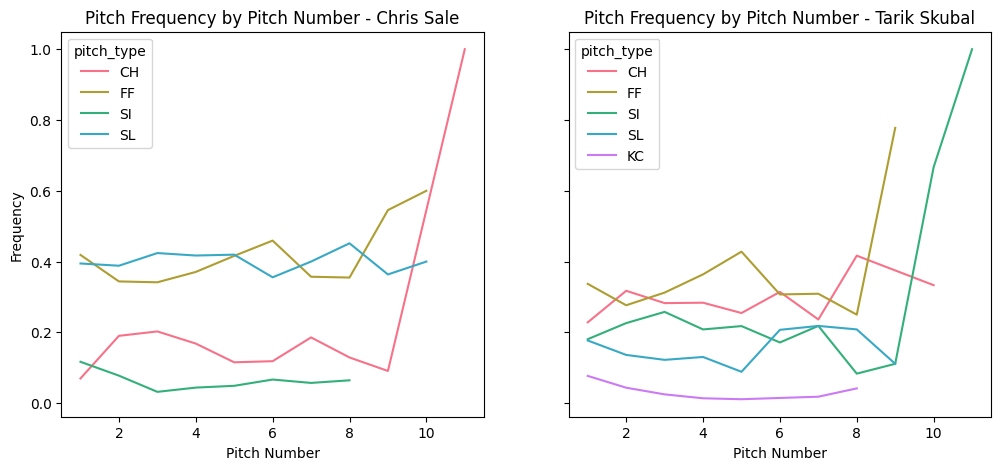

In [17]:
pitch_types = skubal_pitch['pitch_type'].unique()
palette = sns.color_palette("husl", n_colors=len(pitch_types))

plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.lineplot(data=sale_pitch, x='pitch_number', y='Frequency', hue='pitch_type', palette=palette, ax=axes[0])

# Add a title and labels
axes[0].set_title("Pitch Frequency by Pitch Number - Chris Sale")
axes[0].set_xlabel("Pitch Number")
axes[0].set_ylabel("Frequency")

sns.lineplot(data=skubal_pitch, x='pitch_number', y='Frequency', hue='pitch_type', palette=palette, ax=axes[1])

# Add a title and labels
axes[1].set_title("Pitch Frequency by Pitch Number - Tarik Skubal")
axes[1].set_xlabel("Pitch Number")
axes[1].set_ylabel("Frequency")


# Show the plot
plt.show();

For this interpretation, I am really only going to focus on pitches 1-10. The big jump we see in frequency past pitch 10 tells me that they really only reached a pitch number past 10 once, in which they both threw a changeup so the frequency is at 1.0.

Looking at Chris Sale's linegraph of pitch frequency by pitch number, we don't see that many trends in terms of changing direction (i.e. low usage early in counts, high usage later in counts, and vice versa). We see that fastball and slider are consistently frequently used across all pitch numbers, while change up and sinker stay at a lower frequency. This was already seen in the pitch usage plots earlier. One thing that is super interesting about Chris Sale's graph is that his sinker was not used past pitch 8 in the count. Late in the count, he probably wants to use his more comfortable pitches, which are slider and four seam fastball, since he wants to just win the at-bat.

Tarik Skubal's linegraph also does not show much change in direction, but his usage is much more "erratic". We still see that the four-seamer is the most used, mostly, with his changeup being second most used. We also see that is Knuckle-Curve is consistently not used much across the board, which is what we saw in the pitch usage plot. Sinker and slider are more interesting pitches to me in this situation. Even though their change is quite minimal in frequency across pitch numbers, we do see somewhat of a trend. As he gets later in the at-bat, he increases his usage of his slider. Inversely, he decreases his use of his sinker.

These plots tell me that when it comes to using the RNN to predict the next pitch, we will likely see four seam fastball or slider for Chris Sale and either four seam fastball or changeup for Tarik Skubal.

# Situational Pitching

How does their arsenal change based on the situation at hand? Do they pitch differently early in the game vs. late? How do they pitch with no outs vs. with 2 outs? What about when they are ahead in the game versus behind?

Let's first look at how they pitch differently as the game progresses.

In [19]:
def inning(data, pitcher):

    inning = data[['pitch_type', 'inning']].copy()
    inning['Pitcher'] = pitcher
    grouped_inning = inning.groupby(['Pitcher', 'inning', 'pitch_type']).size().reset_index(name='Count')
    grouped_inning['Frequency'] = grouped_inning.groupby(['Pitcher', 'inning'])['Count'].transform(lambda x: x / x.sum())

    return grouped_inning.drop(columns=['Count'])


def reorder_kc_last(df):    # Same as above, but with 'inning' instead of 'pitch_number'

    def sort_key(row):
        if row['inning'] == 'KC':
            return 1
        else:
            return 0

    df['sort_order'] = df.apply(sort_key, axis=1)
    df = df.sort_values(by=['inning', 'sort_order', 'pitch_type'], ascending=[True, True, True])
    df = df.drop(columns=['sort_order'])
    return df

sale_inning = inning(sale, 'Chris Sale')
skubal_inning = inning(skubal, 'Tarik Skubal')
skubal_inning = reorder_kc_last(skubal_inning)

<ipython-input-20-00fd3bd4534b>:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(data=sale_inning, x='inning', y='Frequency', hue='pitch_type', palette=palette, ax=axes[0])


<Figure size 1000x600 with 0 Axes>

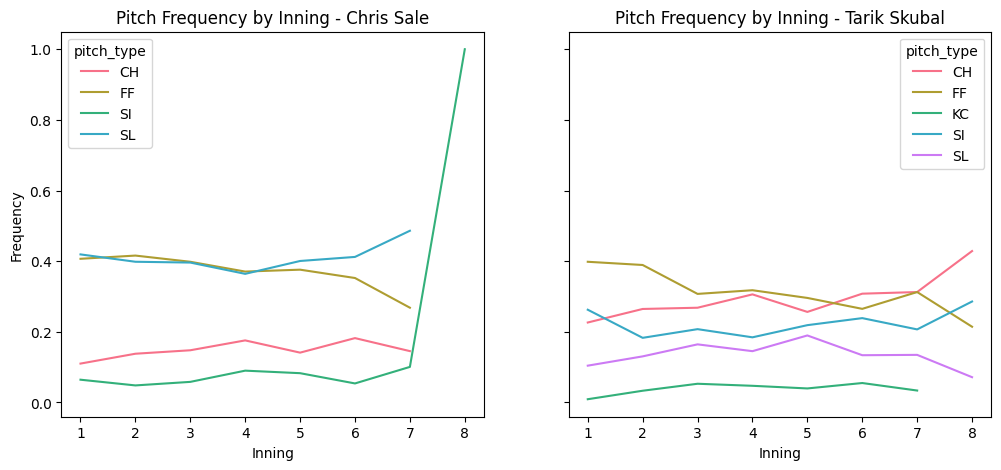

In [20]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.lineplot(data=sale_inning, x='inning', y='Frequency', hue='pitch_type', palette=palette, ax=axes[0])


axes[0].set_title("Pitch Frequency by Inning - Chris Sale")
axes[0].set_xlabel("Inning")
axes[0].set_ylabel("Frequency")

sns.lineplot(data=skubal_inning, x='inning', y='Frequency', hue='pitch_type', palette=palette, ax=axes[1])


axes[1].set_title("Pitch Frequency by Inning - Tarik Skubal")
axes[1].set_xlabel("Inning")
axes[1].set_ylabel("Frequency")


# Show the plot
plt.show();

In [22]:
def outs(data, pitcher):

    outs = data[['pitch_type', 'outs_when_up']].copy()
    outs['Pitcher'] = pitcher
    grouped_outs = outs.groupby(['Pitcher', 'outs_when_up', 'pitch_type']).size().reset_index(name='Count')
    grouped_outs['Frequency'] = grouped_outs.groupby(['Pitcher', 'outs_when_up'])['Count'].transform(lambda x: x / x.sum())

    return grouped_outs.drop(columns=['Count'])

sale_outs = outs(sale, 'Chris Sale')
skubal_outs = outs(skubal, 'Tarik Skubal')

<ipython-input-30-e60c7d098fc3>:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=sale_outs, x='outs_when_up', y='Frequency', hue='pitch_type', palette=palette, ax=axes[0])


<Figure size 1000x600 with 0 Axes>

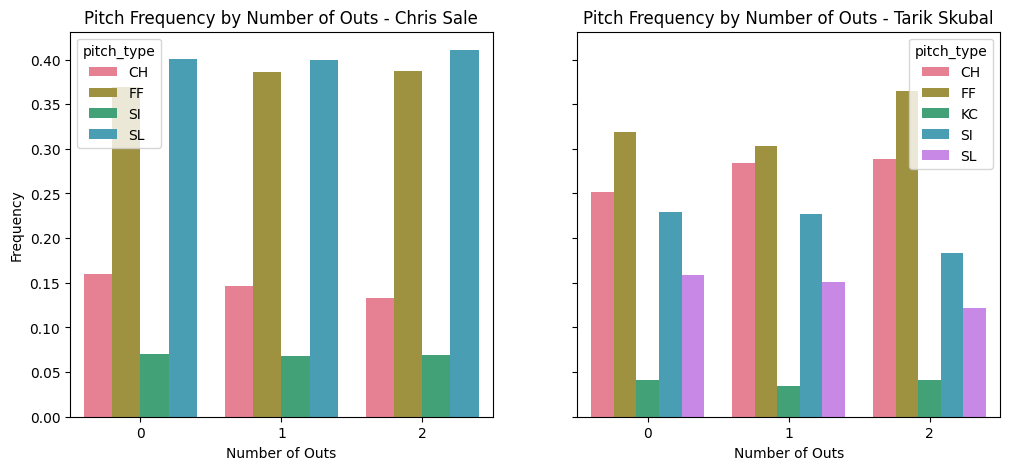

In [30]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.barplot(data=sale_outs, x='outs_when_up', y='Frequency', hue='pitch_type', palette=palette, ax=axes[0])

## Sale Plot
axes[0].set_title("Pitch Frequency by Number of Outs - Chris Sale")
axes[0].set_xlabel("Number of Outs")
axes[0].set_ylabel("Frequency")

sns.barplot(data=skubal_outs, x='outs_when_up', y='Frequency', hue='pitch_type', palette=palette, ax=axes[1])

## Skubal Plot
axes[1].set_title("Pitch Frequency by Number of Outs - Tarik Skubal")
axes[1].set_xlabel("Number of Outs")
axes[1].set_ylabel("Frequency")


# Show the plot
plt.show();

Considering an even count as the pitcher being ahead because there are more balls allowed than strikes

In [37]:
sale_count = sale
sale_count['Status'] = sale_count.apply(lambda row: 'Behind' if row['balls'] > row['strikes'] else 'Ahead', axis=1)

skubal_count = skubal
skubal_count['Status'] = skubal_count.apply(lambda row: 'Behind' if row['balls'] > row['strikes'] else 'Ahead', axis=1)

def count(data, pitcher):

    count = data[['pitch_type', 'Status']].copy()
    count['Pitcher'] = pitcher
    grouped_count = count.groupby(['Pitcher', 'Status', 'pitch_type']).size().reset_index(name='Count')
    grouped_count['Frequency'] = grouped_count.groupby(['Pitcher', 'Status'])['Count'].transform(lambda x: x / x.sum())

    return grouped_count.drop(columns=['Count'])

sale_count2 = count(sale_count, 'Chris Sale')
skubal_count2 = count(skubal_count, 'Tarik Skubal')

<ipython-input-38-b01f8bb39920>:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=sale_count2, x='Status', y='Frequency', hue='pitch_type', palette=palette, ax=axes[0])


<Figure size 1000x600 with 0 Axes>

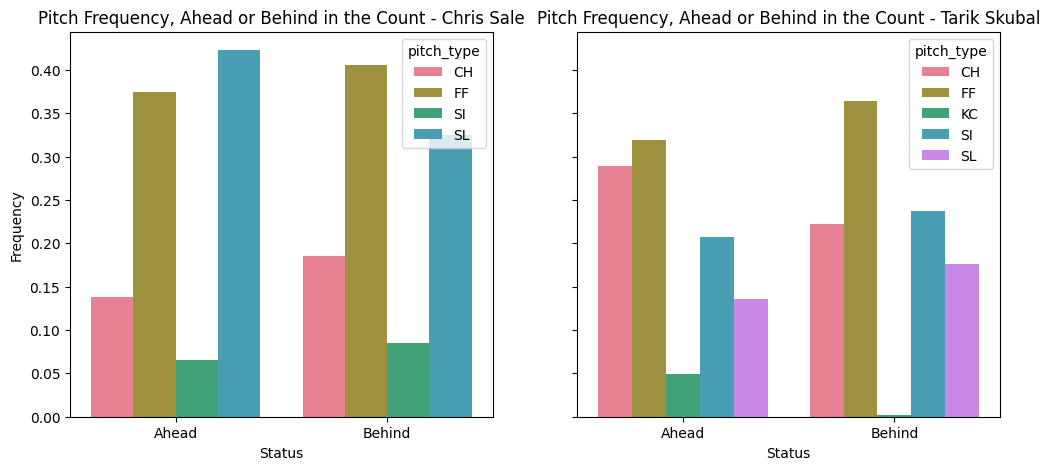

In [38]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.barplot(data=sale_count2, x='Status', y='Frequency', hue='pitch_type', palette=palette, ax=axes[0])

## Sale Plot
axes[0].set_title("Pitch Frequency, Ahead or Behind in the Count - Chris Sale")
axes[0].set_xlabel("Status")
axes[0].set_ylabel("Frequency")

sns.barplot(data=skubal_count2, x='Status', y='Frequency', hue='pitch_type', palette=palette, ax=axes[1])

## Skubal Plot
axes[1].set_title("Pitch Frequency, Ahead or Behind in the Count - Tarik Skubal")
axes[1].set_xlabel("Status")
axes[1].set_ylabel("Frequency")


# Show the plot
plt.show();